<a href="https://colab.research.google.com/github/emilymacris/ds2002-dp3/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/emilymacris/ds4002-project3

Cloning into 'ds4002-project3'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 28 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 1.34 MiB | 15.64 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install earthengine-api
!pip install geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.3 MB/s eta 0:00:00


In [ ]:
import ee
import geemap

In [ ]:
ee.Authenticate()
ee.Initialize(project='ee-bdf7bz')


In [ ]:
aoi = ee.Geometry.Rectangle([-147.5, 60.7, -146.5, 61.3])  # Columbia Glacier area

# Use the new Collection 2 dataset
image = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(aoi) \
    .filterDate('2021-06-01', '2021-08-31') \
    .median() \
    .clip(aoi)

Map = geemap.Map(center=[60.9, -147.0], zoom=9)
Map.addLayer(image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 30000}, 'True Color')
Map


Map(center=[60.9, -147.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
# Compute NDSI (snow/ice index)
ndsi = image.normalizedDifference(['SR_B3', 'SR_B6']).rename('NDSI')

# Compute NDVI (vegetation index)
ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

# Add them to your image
image = image.addBands([ndsi, ndvi])

In [ ]:
stats = image.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        ee.Reducer.minMax(), sharedInputs=True
    ),
    geometry=aoi,
    scale=30,
    maxPixels=1e9  # set this high enough
)

print(stats.getInfo())

{'NDSI_max': 0.6992718423254874, 'NDSI_mean': 0.27645546402542265, 'NDSI_min': -0.24924760601915186, 'NDVI_max': 0.49193415019168607, 'NDVI_mean': 0.002331219555157145, 'NDVI_min': -0.24774450769641793, 'QA_PIXEL_max': 55052, 'QA_PIXEL_mean': 29214.648746123956, 'QA_PIXEL_min': 21824, 'QA_RADSAT_max': 0, 'QA_RADSAT_mean': 0, 'QA_RADSAT_min': 0, 'SR_B1_max': 51294, 'SR_B1_mean': 27955.507232166034, 'SR_B1_min': 7268.5, 'SR_B2_max': 51687, 'SR_B2_mean': 27746.568657031075, 'SR_B2_min': 7390.5, 'SR_B3_max': 50195, 'SR_B3_mean': 26570.27409479051, 'SR_B3_min': 7616, 'SR_B4_max': 49245, 'SR_B4_mean': 26063.758652711276, 'SR_B4_min': 7233.5, 'SR_B5_max': 43481, 'SR_B5_mean': 25575.654640620916, 'SR_B5_min': 7181.5, 'SR_B6_max': 25396.5, 'SR_B6_mean': 13499.973213853438, 'SR_B6_min': 7273, 'SR_B7_max': 20268.5, 'SR_B7_mean': 13170.400187243331, 'SR_B7_min': 7438.5, 'SR_QA_AEROSOL_max': 224, 'SR_QA_AEROSOL_mean': 204.24971759211613, 'SR_QA_AEROSOL_min': 1, 'ST_ATRAN_max': 9404, 'ST_ATRAN_mean'

In [ ]:
training_points = ee.FeatureCollection('users/bdf7bz/glacier_training')


In [ ]:
training_data = image.sampleRegions(
    collection=training_points,
    properties=['class'],  # label column
    scale=30
)

In [ ]:
import pandas as pd
import json

# Convert EE FeatureCollection to GeoJSON dictionary
geojson = geemap.ee_to_geojson(training_data)

# Convert to pandas DataFrame
df = pd.json_normalize(geojson['features'])

# Preview
df.head()

,type,geometry,id,properties.NDSI,properties.NDVI,properties.QA_PIXEL,properties.QA_RADSAT,properties.SR_B1,properties.SR_B2,properties.SR_B3,...,properties.ST_ATRAN,properties.ST_B10,properties.ST_CDIST,properties.ST_DRAD,properties.ST_EMIS,properties.ST_EMSD,properties.ST_QA,properties.ST_TRAD,properties.ST_URAD,properties.class
0,Feature,None,00000000000000000000_0,0.296557,-0.008578,22280,0,36202.5,35741.0,33392.5,...,7932.0,35916.5,0.0,634.5,9706.0,65,679.0,6056.5,1276.5,1
1,Feature,None,00000000000000000001_0,0.287143,-0.004286,22280,0,39003.5,38574.0,36059.0,...,8171.0,34615.5,0.0,563.0,9696.0,0,686.0,5743.0,1112.0,1
2,Feature,None,00000000000000000002_0,0.356426,-0.014171,22280,0,37301.0,36856.5,34704.5,...,7809.0,34994.5,0.0,690.5,9658.0,57,687.5,5744.5,1387.5,1
3,Feature,None,00000000000000000003_0,0.329418,-0.014913,23212,0,35747.5,35647.0,34126.5,...,8200.5,33530.5,0.0,555.0,9534.0,60,687.0,5337.0,1094.0,1
4,Feature,None,00000000000000000004_0,0.329722,-0.004062,22280,0,36560.5,36077.5,34241.0,...,8375.5,33855.0,0.0,490.0,9712.0,140,676.5,5325.5,952.0,1


In [ ]:
# Clean column names (remove 'properties.' prefix)
df.columns = df.columns.str.replace('properties.', '', regex=False)

# Drop unnecessary columns
drop_cols = ['type', 'geometry', 'id']
df_clean = df.drop(columns=drop_cols)

# Preview cleaned data
df_clean.head()

,NDSI,NDVI,QA_PIXEL,QA_RADSAT,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,...,ST_ATRAN,ST_B10,ST_CDIST,ST_DRAD,ST_EMIS,ST_EMSD,ST_QA,ST_TRAD,ST_URAD,class
0,0.296557,-0.008578,22280,0,36202.5,35741.0,33392.5,32890.5,32331.0,18117.0,...,7932.0,35916.5,0.0,634.5,9706.0,65,679.0,6056.5,1276.5,1
1,0.287143,-0.004286,22280,0,39003.5,38574.0,36059.0,35677.5,35373.0,19970.5,...,8171.0,34615.5,0.0,563.0,9696.0,0,686.0,5743.0,1112.0,1
2,0.356426,-0.014171,22280,0,37301.0,36856.5,34704.5,34281.0,33323.0,16466.0,...,7809.0,34994.5,0.0,690.5,9658.0,57,687.5,5744.5,1387.5,1
3,0.329418,-0.014913,23212,0,35747.5,35647.0,34126.5,33824.0,32830.0,17214.0,...,8200.5,33530.5,0.0,555.0,9534.0,60,687.0,5337.0,1094.0,1
4,0.329722,-0.004062,22280,0,36560.5,36077.5,34241.0,33620.0,33348.0,17260.0,...,8375.5,33855.0,0.0,490.0,9712.0,140,676.5,5325.5,952.0,1


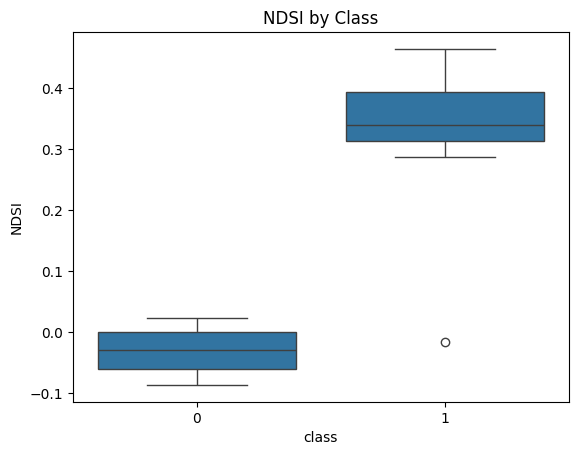

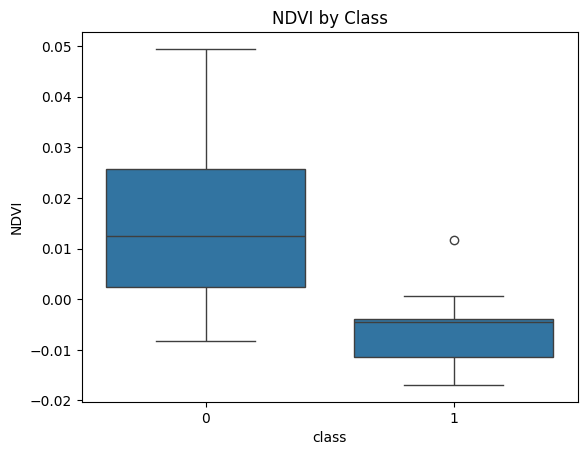

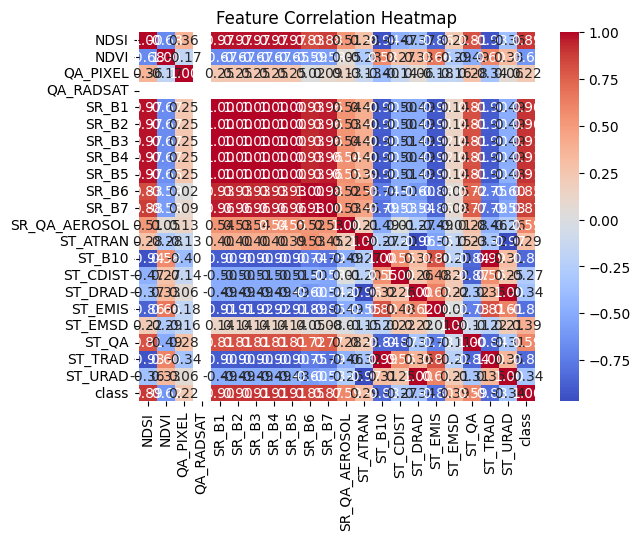

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of NDSI and NDVI by class
sns.boxplot(x='class', y='NDSI', data=df_clean)
plt.title('NDSI by Class')
plt.show()

sns.boxplot(x='class', y='NDVI', data=df_clean)
plt.title('NDVI by Class')
plt.show()

# Correlation heatmap
sns.heatmap(df_clean.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

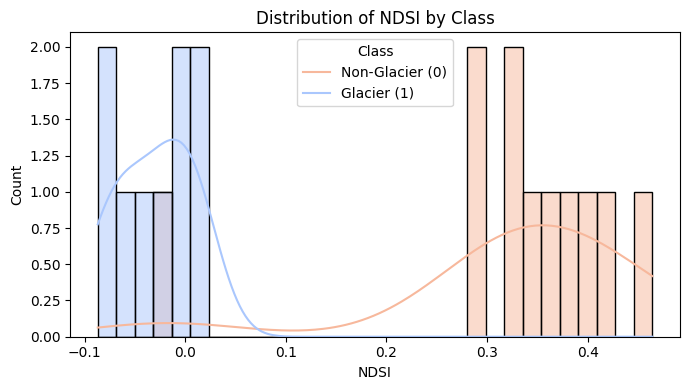

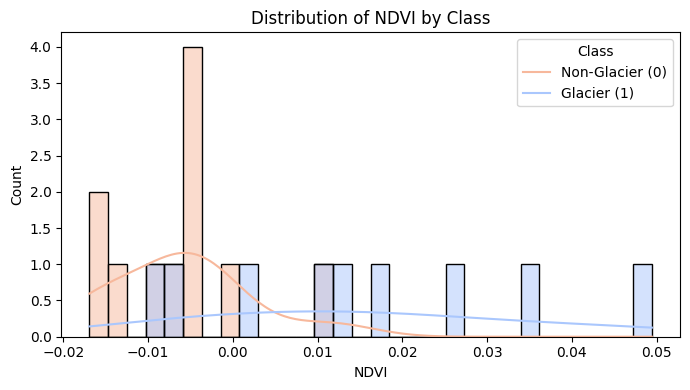

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for NDSI and NDVI
features = ['NDSI', 'NDVI']
for feature in features:
    plt.figure(figsize=(7, 4))
    sns.histplot(data=df_clean, x=feature, hue='class', kde=True, palette='coolwarm', bins=30)
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Class', labels=['Non-Glacier (0)', 'Glacier (1)'])
    plt.tight_layout()
    plt.show()

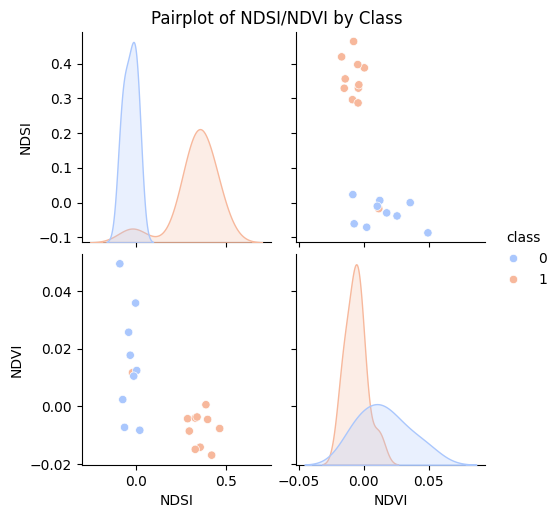

In [ ]:
# Only select relevant columns
plot_features = ['NDSI', 'NDVI', 'class']
sns.pairplot(df_clean[plot_features], hue='class', palette='coolwarm', diag_kind='kde')
plt.suptitle("Pairplot of NDSI/NDVI by Class", y=1.02)
plt.show()


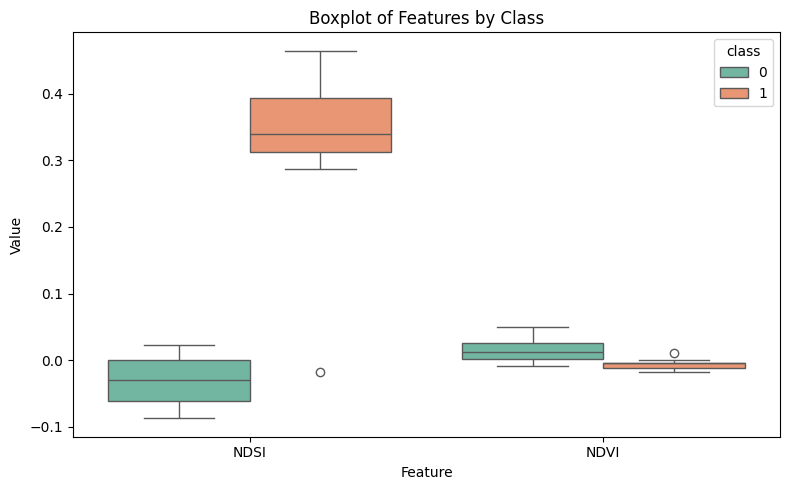

In [ ]:
# Melt the DataFrame for boxplotting
melted = df_clean.melt(id_vars='class', value_vars=['NDSI', 'NDVI'])

plt.figure(figsize=(8, 5))
sns.boxplot(x='variable', y='value', hue='class', data=melted, palette='Set2')
plt.title("Boxplot of Features by Class")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


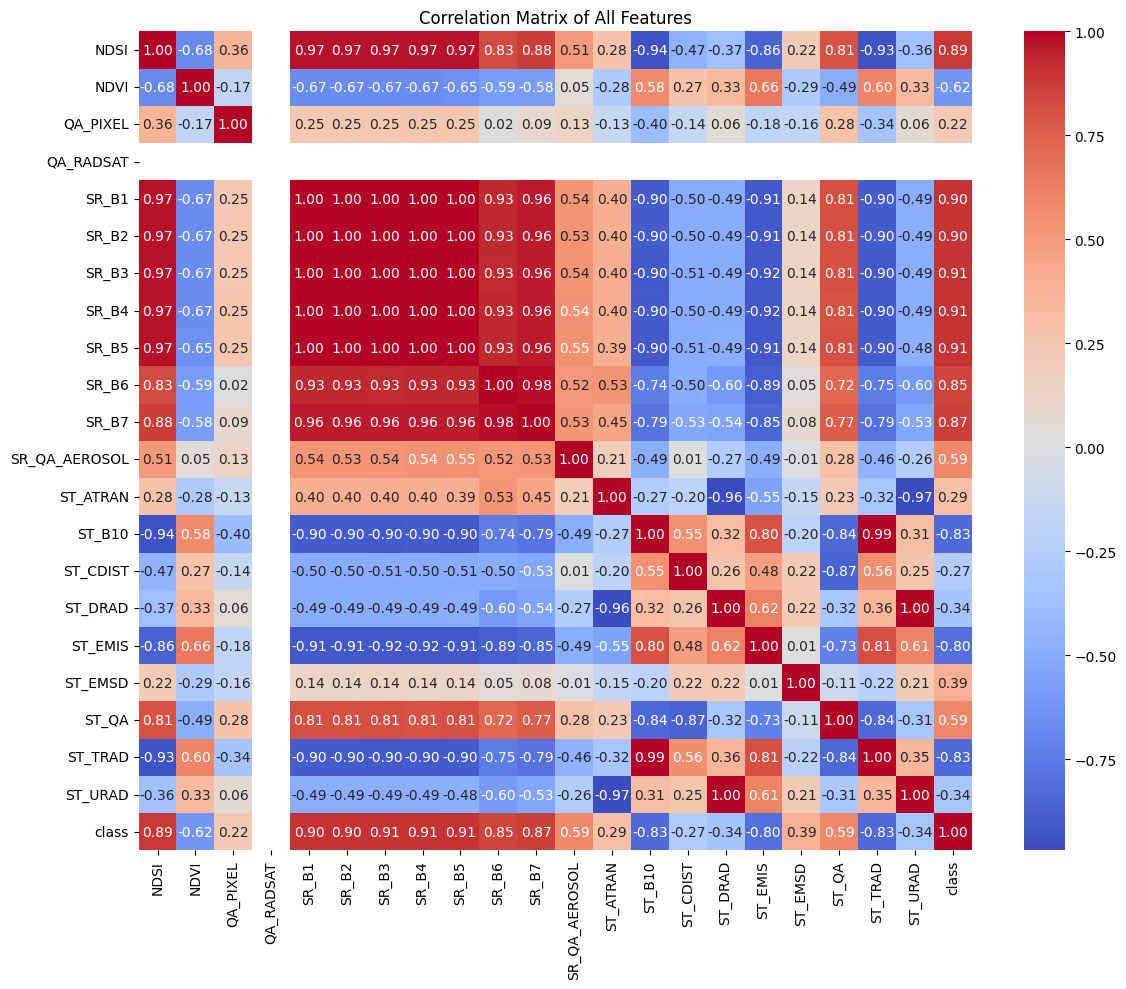

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of All Features")
plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
import pandas as pd

# Replace with the actual shared path
base_path = '/content/drive/MyDrive/DS4002_Project/P3_Emily_Karan/'

# Load glacier polygons (class 1)
gdf_g1 = gpd.read_file(base_path + 'sample_glacier1.geojson')
gdf_g2 = gpd.read_file(base_path + 'sample_glacier2.geojson')
gdf_g3 = gpd.read_file(base_path + 'sample_glacier3.geojson')  # Add more as needed
gdf_g4 = gpd.read_file(base_path + 'sample_glacier4.geojson')
gdf_g5 = gpd.read_file(base_path + 'sample_glacier5.geojson')
gdf_g6 = gpd.read_file(base_path + 'sample_glacier6.geojson')

# Combine all glacier samples into a single DataFrame
glacier_df = pd.concat([gdf_g1, gdf_g2, gdf_g3, gdf_g4, gdf_g5, gdf_g6], ignore_index=True)

# Optional: Preview the data
glacier_df.head()



,id,NDSI,NDVI,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,class,geometry
0,0_0,0.338488,-0.001883,34198.5,32157.5,31661.5,31542.5,15893.0,15303.0,1,MULTIPOINT EMPTY
1,0_1,0.348116,-0.002242,34108.5,32116.5,31633.5,31492.0,15530.0,15230.5,1,MULTIPOINT EMPTY
2,0_2,0.348116,-0.002242,34108.5,32116.5,31633.5,31492.0,15530.0,15230.5,1,MULTIPOINT EMPTY
3,0_3,0.352595,-0.002040,34052.0,32092.0,31561.5,31433.0,15360.5,15064.0,1,MULTIPOINT EMPTY
4,0_4,0.352595,-0.002040,34052.0,32092.0,31561.5,31433.0,15360.5,15064.0,1,MULTIPOINT EMPTY


In [ ]:
ngdf1 = gpd.read_file(base_path + 'sample_nonglacier1.geojson')
ngdf2 = gpd.read_file(base_path + 'sample_nonglacier2.geojson')
ngdf3 = gpd.read_file(base_path + 'sample_nonglacier3.geojson')
ngdf4 = gpd.read_file(base_path + 'sample_nonglacier4.geojson')
ngdf5 = gpd.read_file(base_path + 'sample_nonglacier5.geojson')
ngdf6 = gpd.read_file(base_path + 'sample_nonglacier6.geojson')

# Combine them all into a single dataframe
nonglacier_df = pd.concat([ngdf1, ngdf2, ngdf3, ngdf4, ngdf5, ngdf6], ignore_index=True)

# Check shape and preview
print("Non-glacier samples:", nonglacier_df.shape)
nonglacier_df.head()


Non-glacier samples: (1508982, 11)


,id,NDSI,NDVI,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,class,geometry
0,0_0,-0.064484,0.049278,8283.5,8871.5,8035.5,8868.5,10094.5,10195.5,0,MULTIPOINT EMPTY
1,0_1,-0.069535,0.051910,8296.5,8758.0,7922.0,8789.5,10067.0,10141.5,0,MULTIPOINT EMPTY
2,0_2,-0.069535,0.051910,8296.5,8758.0,7922.0,8789.5,10067.0,10141.5,0,MULTIPOINT EMPTY
3,0_3,-0.069248,0.052091,8273.5,8629.0,7797.5,8654.5,9913.0,10010.0,0,MULTIPOINT EMPTY
4,0_4,-0.069248,0.052091,8273.5,8629.0,7797.5,8654.5,9913.0,10010.0,0,MULTIPOINT EMPTY


In [ ]:
# Combine glacier and non-glacier samples
all_samples = pd.concat([glacier_df, nonglacier_df], ignore_index=True)

# Drop geometry column if it's empty (optional)
all_samples = all_samples.drop(columns='geometry')

# Check class balance
print(all_samples['class'].value_counts())

class
0    1508982
1    1405386
Name: count, dtype: int64


Confusion Matrix:
[[3096    0]
 [   0 2904]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3096
           1       1.00      1.00      1.00      2904

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



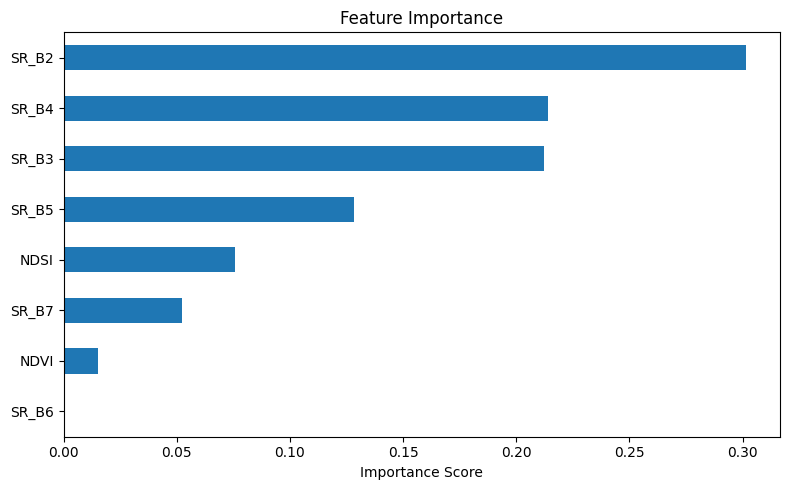

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# Optional: Remove duplicate rows
all_samples_clean = all_samples.drop_duplicates()

# Optional: Subsample to reduce memory load
all_samples_clean = all_samples_clean.sample(n=20000, random_state=42)

# ----------------------------------------
# Features and labels
X = all_samples_clean.drop(columns=['class', 'id', 'geometry'], errors='ignore')
y = all_samples_clean['class']

# Optional: Add slight noise
X = X + np.random.normal(0, 0.01, size=X.shape)

# ----------------------------------------
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# ----------------------------------------
# Initialize and train with regularization
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)
clf.fit(X_train, y_train)

# ----------------------------------------
# Predict and evaluate
y_pred = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ----------------------------------------
# Optional: Feature importance
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 5), title='Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


In [ ]:
# Already loaded glacier and non-glacier samples separately
# fixing
glacier_df['polygon_id'] = 'glacier'
nonglacier_df['polygon_id'] = 'non_glacier'

# Merge into one
all_samples = pd.concat([glacier_df, nonglacier_df], ignore_index=True)


In [ ]:
from sklearn.model_selection import train_test_split

# Unique polygons
polygon_ids = all_samples['polygon_id'].unique()

# Train-test split by polygon
train_ids, test_ids = train_test_split(polygon_ids, test_size=0.3, random_state=42)

# Create train/test sets
train_samples = all_samples[all_samples['polygon_id'].isin(train_ids)]
test_samples = all_samples[all_samples['polygon_id'].isin(test_ids)]

# Features and labels
X_train = train_samples.drop(columns=['class', 'id', 'geometry', 'polygon_id'], errors='ignore')
y_train = train_samples['class']

X_test = test_samples.drop(columns=['class', 'id', 'geometry', 'polygon_id'], errors='ignore')
y_test = test_samples['class']


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize with less overfitting
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',  # don't use all features
    random_state=42
)

clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[      0 1508982]
 [      0       0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00 1508982.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00 1508982.0
   macro avg       0.00      0.00      0.00 1508982.0
weighted avg       0.00      0.00      0.00 1508982.0



Confusion Matrix:
[[3096    0]
 [   0 2904]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3096
           1       1.00      1.00      1.00      2904

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



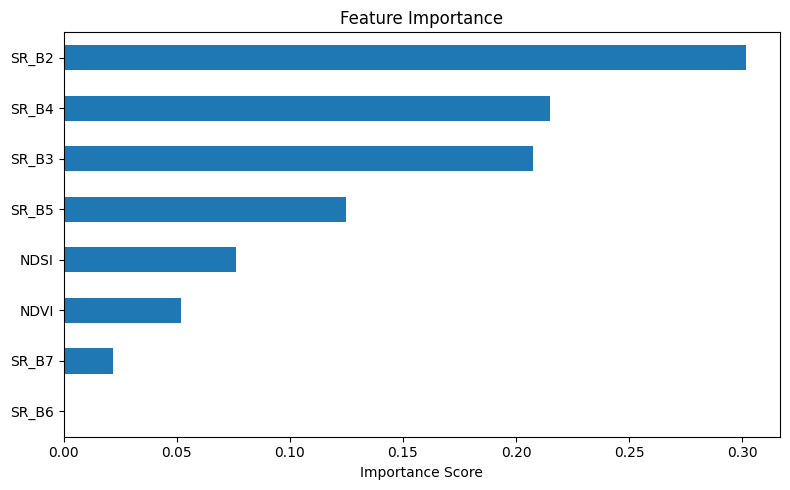

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# ----------------------------------------
# Optional: Remove duplicate rows (based on all feature columns)
all_samples_clean = all_samples.drop_duplicates()

# Optional: Subsample to reduce memory load (use a stratified sample if very large)
all_samples_clean = all_samples_clean.sample(n=20000, random_state=42)

# ----------------------------------------
# Features and labels
X = all_samples_clean.drop(columns=['class', 'id', 'geometry'], errors='ignore')  # Drop unnecessary cols
y = all_samples_clean['class']

# ----------------------------------------
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# ----------------------------------------
# Initialize and train
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ----------------------------------------
# Predict and evaluate
y_pred = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ----------------------------------------
# Optional: Feature importance
import matplotlib.pyplot as plt

importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 5), title='Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


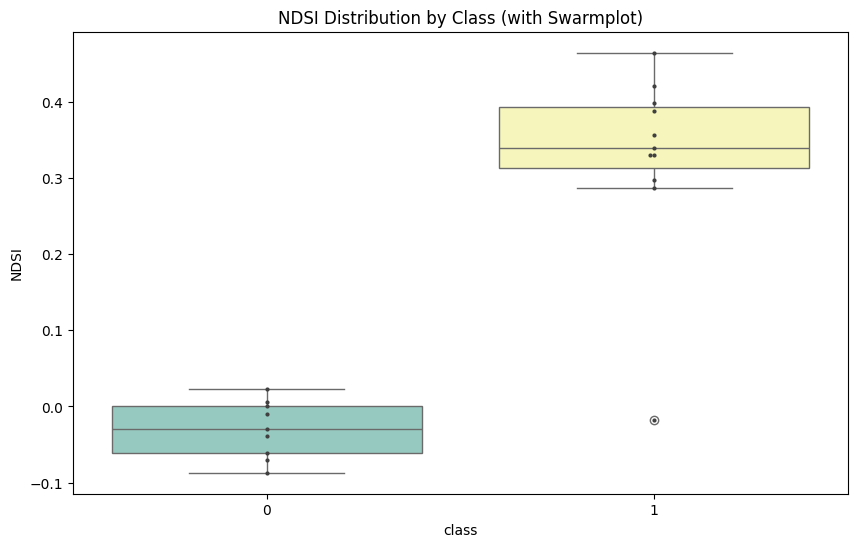

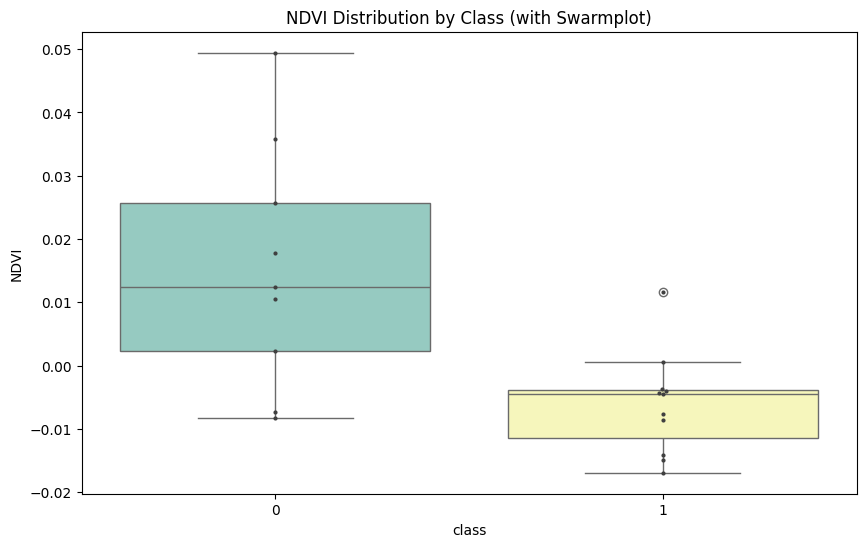

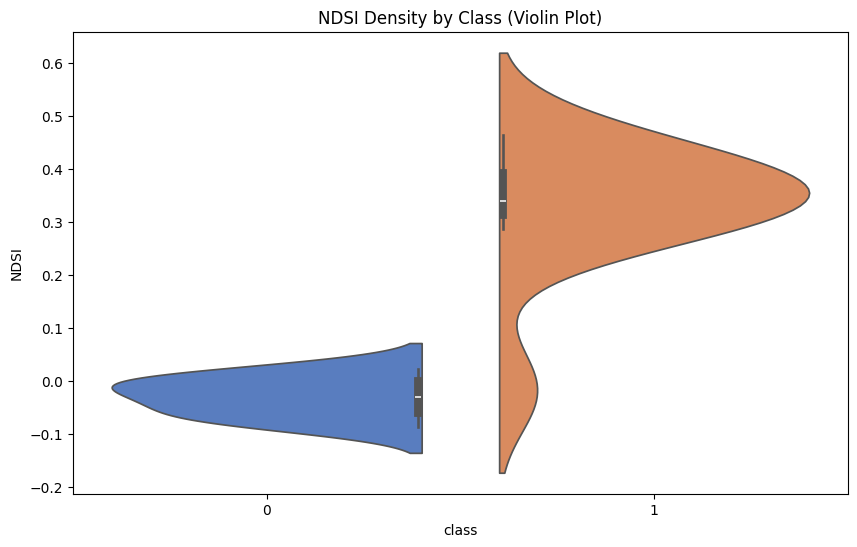

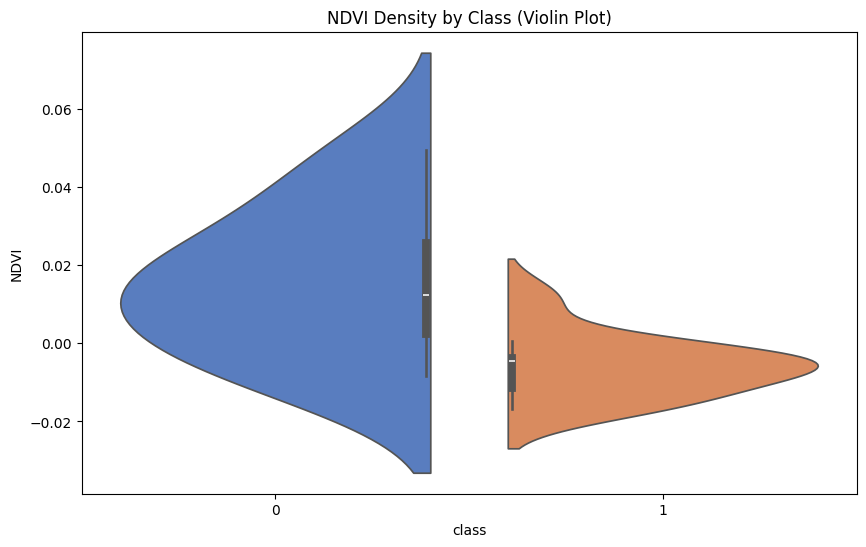

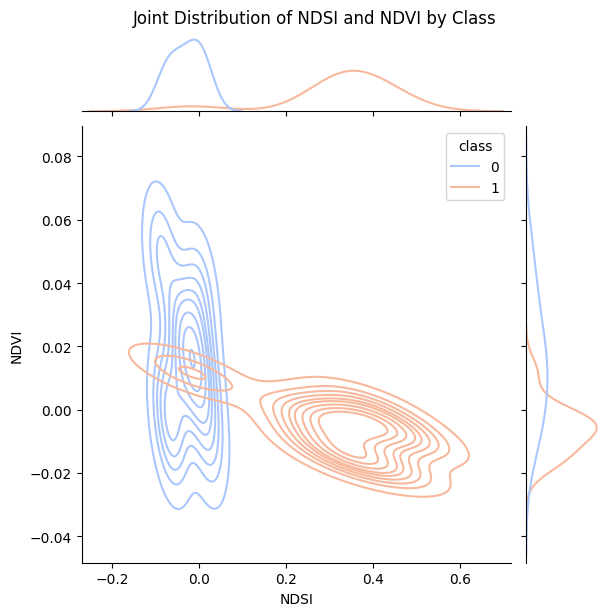

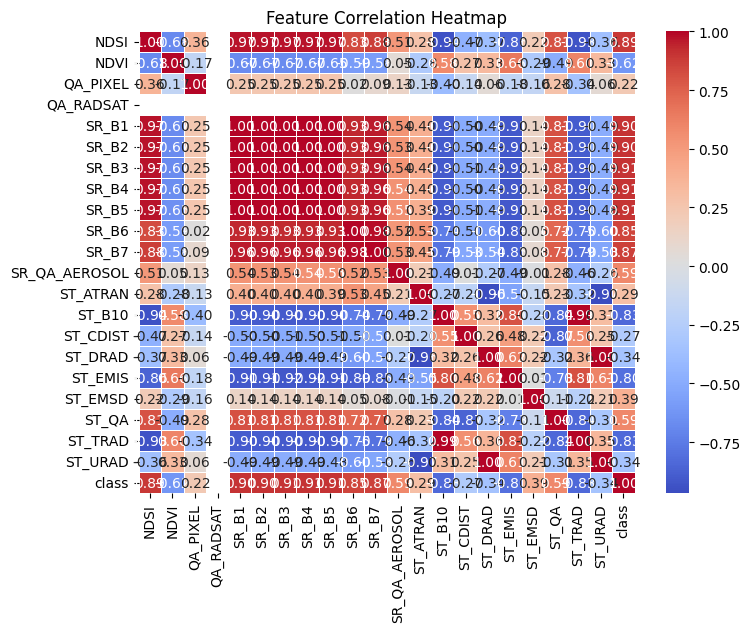

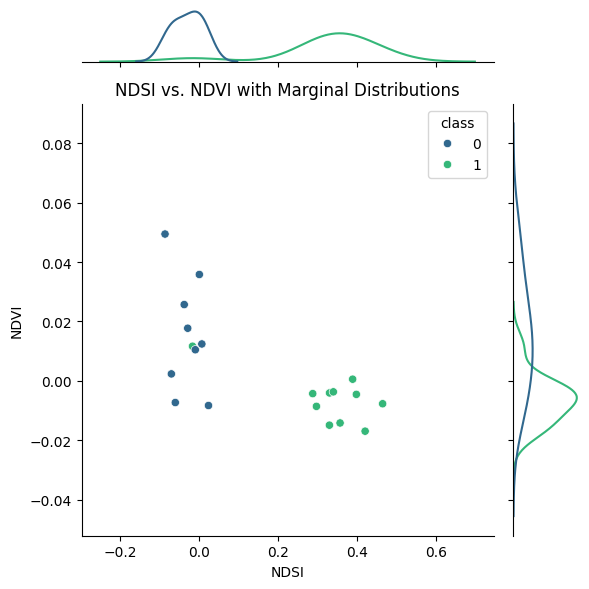

In [ ]:
# prompt: can you do some eda plots with all of this data ? please, visualize etc and then interpret

import matplotlib.pyplot as plt
# Assuming df_clean from the previous code is available

# Enhanced visualizations and interpretations

# 1. Improved Boxplots with Swarmplot Overlay:
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='NDSI', data=df_clean, palette='Set3')
sns.swarmplot(x='class', y='NDSI', data=df_clean, color=".25", size=3)  # Overlay swarmplot
plt.title('NDSI Distribution by Class (with Swarmplot)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='NDVI', data=df_clean, palette='Set3')
sns.swarmplot(x='class', y='NDVI', data=df_clean, color=".25", size=3)
plt.title('NDVI Distribution by Class (with Swarmplot)')
plt.show()

# Interpretation: Swarmplot shows individual data points, helping visualize the distribution density within each class and potential overlaps.


# 2. Violin Plots for Density Representation:
plt.figure(figsize=(10, 6))
sns.violinplot(x='class', y='NDSI', data=df_clean, palette="muted", split=True)
plt.title('NDSI Density by Class (Violin Plot)')
plt.show()


plt.figure(figsize=(10, 6))
sns.violinplot(x='class', y='NDVI', data=df_clean, palette="muted", split=True)
plt.title('NDVI Density by Class (Violin Plot)')
plt.show()

# Interpretation: Violin plots show the distribution density of each class, complementing boxplots by providing a more detailed view of the data's shape.


# 3. Jointplot for Bivariate Analysis:
sns.jointplot(x='NDSI', y='NDVI', data=df_clean, hue='class', kind='kde', palette='coolwarm')
plt.suptitle('Joint Distribution of NDSI and NDVI by Class', y=1.02)
plt.show()

# Interpretation: Observe the relationship between NDSI and NDVI for each class. Look for distinct clusters or overlaps in the distributions.


# 4.  Enhanced Correlation Heatmap:
plt.figure(figsize=(8, 6))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5) # Added linewidths
plt.title("Feature Correlation Heatmap")
plt.show()

# Interpretation:  Examine the correlation between features, which can indicate potential redundancy or important interactions in the data.


# 5. Scatter Plots with Marginal Distributions (JointGrid):
g = sns.JointGrid(data=df_clean, x="NDSI", y="NDVI", hue="class", palette='viridis')
g.plot(sns.scatterplot, sns.kdeplot)
g.ax_joint.set_title("NDSI vs. NDVI with Marginal Distributions")
g.fig.tight_layout()
plt.show()

# Interpretation: Helps visualize both the bivariate relationship and the individual distribution of each variable for better insights.

# Additional interpretations:
# - Look for differences in the mean, median, and spread of NDSI and NDVI between the two classes.
# -  Significant differences suggest these features are important predictors.
# - Note if any features show high correlation and discuss their implications for modeling.
# -  Based on these initial visualizations, form hypotheses about how each feature might be used for classification.


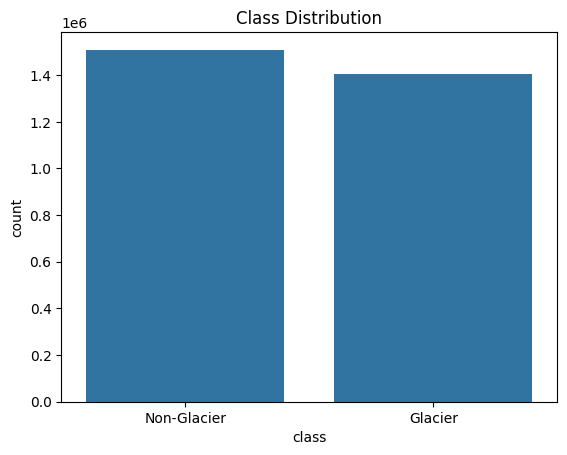

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=all_samples, x='class')
plt.title("Class Distribution")
plt.xticks([0, 1], ['Non-Glacier', 'Glacier'])
plt.show()

In [ ]:
# Drop duplicates
all_samples_deduped = all_samples.drop_duplicates()

# Check balance again
print(all_samples_deduped['class'].value_counts())


class
0    1508982
1    1405386
Name: count, dtype: int64


In [ ]:
from sklearn.utils import resample

# Separate classes
glacier = all_samples_deduped[all_samples_deduped['class'] == 1]
nonglacier = all_samples_deduped[all_samples_deduped['class'] == 0]

# Downsample the majority class
nonglacier_downsampled = resample(nonglacier,
                                  replace=False,
                                  n_samples=len(glacier),
                                  random_state=42)

# Combine
balanced_samples = pd.concat([glacier, nonglacier_downsampled])


In [ ]:
X = balanced_samples.drop(columns=['class', 'id', 'geometry'], errors='ignore')
y = balanced_samples['class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[421616      0]
 [     0 421616]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    421616
           1       1.00      1.00      1.00    421616

    accuracy                           1.00    843232
   macro avg       1.00      1.00      1.00    843232
weighted avg       1.00      1.00      1.00    843232

